In [1]:
import urllib2, cStringIO
import json
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import urllib, simplejson
import requests
import StringIO
import time

from dateutil import parser, rrule
import io
import seaborn as sns

In [2]:
df2011 = pd.read_csv('./collisions_2011.csv')
df2012 = pd.read_csv('./collisions_2012.csv')
df2013 = pd.read_csv('./collisions_2013.csv')
df2014 = pd.read_csv('./collisions_2014.csv')
df2015 = pd.read_csv('./collisions_2015.csv')
df2016 = pd.read_csv('./collisions_2016.csv')

googleGeocodeUrl = 'http://maps.googleapis.com/maps/api/geocode/json?'
def get_coordinates(query, from_sensor=False):
    query = query.encode('utf-8')
    params = {
        'address': query,
        'sensor': "true" if from_sensor else "false"
    }
    url = googleGeocodeUrl + urllib.urlencode(params)
    json_response = urllib.urlopen(url)
    response = simplejson.loads(json_response.read())
    if response['results']:
        location = response['results'][0]['geometry']['location']
        latitude, longitude = location['lat'], location['lng']
    else:
        latitude, longitude = 0, 0
    return [latitude, longitude]

latLonDict = {}
for index,item in df2011.iterrows():
    #get_coordinates(data+', Surrey, Canada')
    loc = item['HUNDRED_BLOCK']
    
    if (loc.find('/') != -1):
        loc = loc[:loc.find('/')-1]
    if loc in latLonDict.keys(): 
        #item['Latitude'],item['Longitude'] = latLonDict[loc][0],latLonDict[loc][1]
        continue
    latLonDict[loc] = [0, 0]
    #latLonDict[loc] = get_coordinates(loc+', Surrey, Canada')
    #item['Latitude'],item['Longitude'] = latLonDict[loc][0],latLonDict[loc][1]
    #time.sleep(0.2)
for index,item in df2012.iterrows():
    loc = item['HUNDRED_BLOCK']
    if (loc.find('/') != -1):
        loc = loc[:loc.find('/')-1]
    if loc in latLonDict.keys(): 
        continue
    latLonDict[loc] = [0, 0]
for index,item in df2013.iterrows():
    loc = item['HUNDRED_BLOCK']
    if (loc.find('/') != -1):
        loc = loc[:loc.find('/')-1]
    if loc in latLonDict.keys(): 
        continue
    latLonDict[loc] = [0, 0]
for index,item in df2014.iterrows():
    loc = str(item['ROAD_NAME'])
    if (loc.find('/') != -1):
        loc = loc[:loc.find('/')-1]
    if loc in latLonDict.keys(): 
        continue
    latLonDict[loc] = [0, 0]
for index,item in df2015.iterrows():
    loc = item['HUNDRED_BLOCK']
    if (loc.find('/') != -1):
        loc = loc[:loc.find('/')-1]
    if loc in latLonDict.keys(): 
        continue
    latLonDict[loc] = [0, 0]
for index,item in df2016.iterrows():
    loc = item['HUNDRED_BLOCK']
    if (loc.find('/') != -1):
        loc = loc[:loc.find('/')-1]
    if loc in latLonDict.keys(): 
        continue
    latLonDict[loc] = [0, 0]


print 'Total unique addresses:',len(latLonDict.keys())

# json.dump(latLonDict, open("locDict.txt",'w'))

Total unique addresses: 8530


In [15]:
latLonDict = json.load(open("locDict_new.txt"))
count = 200;
for key in latLonDict.keys():
    if latLonDict[key]==[0,0]:
        latLonDict[key] = get_coordinates(key + ', Surrey, Canada')
        time.sleep(0.2)
        count -= 1
    if count<1: break
json.dump(latLonDict, open("locDict_new.txt",'w'))

In [3]:
latLonDict = json.load(open("locDict_new.txt"))
count = 0
for key in latLonDict.keys():
    if latLonDict[key]!=[0,0]:
        count+=1
print count

8530


In [8]:
latLonDict2 = json.load(open("locDict.txt"))
for key in latLonDict.keys():
    if key in latLonDict2.keys():
        latLonDict[key] = latLonDict2[key]


In [4]:
#refine Data
df2012.drop('INCIDENT_TYPE',axis=1,inplace=True)
df2013.drop('INCIDENT_TYPE',axis=1,inplace=True)
df2014['HUNDRED_BLOCK'] = df2014['ROAD_NAME']
df2014.drop(['CRIME_TYPE','ROAD_NAME'],axis=1,inplace=True)
df2015.drop('INCIDENT_TYPE',axis=1,inplace=True)
df2016.drop('INCIDENT_TYPE',axis=1,inplace=True)

def refineAddress(df):
    for index,item in df.iterrows():
        refinedLoc = str(item['HUNDRED_BLOCK'])
        if refinedLoc.find('/') != -1:
            refinedLoc = str(refinedLoc[:refinedLoc.find('/')-1])
            df.loc[index, "HUNDRED_BLOCK"] = refinedLoc
    
refineAddress(df2011)
refineAddress(df2012)
refineAddress(df2013)
refineAddress(df2014)
refineAddress(df2015)
refineAddress(df2016)

In [5]:
def fillLatLon(df):
    for index,item in df.iterrows():
        df.loc[index, "Latitude"] = latLonDict[str(item["HUNDRED_BLOCK"])][0]
        df.loc[index, "Longitude"] = latLonDict[str(item["HUNDRED_BLOCK"])][1]
fillLatLon(df2011)
fillLatLon(df2012)
fillLatLon(df2013)
fillLatLon(df2014)
fillLatLon(df2015)
fillLatLon(df2016)

In [6]:
print 'Total unique addresses:',len(latLonDict.keys())
print 'Total Collisions: ', len(df2011)+len(df2012)+len(df2013)+len(df2014)+len(df2015)+len(df2016)

Total unique addresses: 8530
Total Collisions:  48095


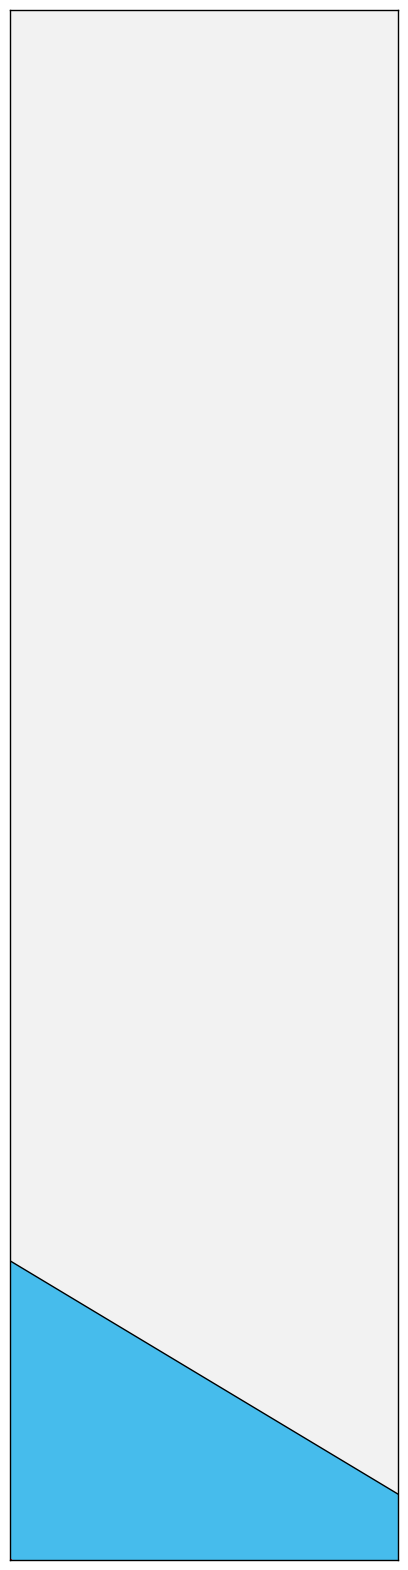

In [10]:
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(10,20))
m = Basemap(resolution='c', # c, l, i, h, f or None
            projection='merc',
            lat_0=48.85, lon_0=-122.75,
            llcrnrlon=-123., llcrnrlat= 48.7, urcrnrlon=-122.5, urcrnrlat=50.)

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
plt.plot(map(float,list(df2011.Latitude)),map(float,list(df2011.Longitude)),'.r')
plt.show()

In [16]:
import gmplot

gmap = gmplot.GoogleMapPlotter(49.1, -122.8, 16)

gmap.plot(df2011.Latitude, df2011.Longitude, 'cornflowerblue', edge_width=10)
#gmap.scatter(more_lats, more_lngs, '#3B0B39', size=40, marker=False)
#gmap.scatter(marker_lats, marker_lngs, 'k', marker=True)
#gmap.heatmap(heat_lats, heat_lngs)

gmap.draw("mymap.html")

In [19]:
for i,item in df2011.iterrows():
    print str(item['Latitude'])+','+str(item['Longitude'])

49.0455189,-122.7935876
49.1172237,-122.8008932
49.1482267,-122.7683628
49.1660884,-122.8013841
49.1191211,-122.8197617
49.0455189,-122.7935876
49.1336419,-122.8534627
49.1172237,-122.8008932
49.1631312,-122.8783788
49.1191096,-122.8147461
49.1771395,-122.8901951
49.119069,-122.823373
49.1863737,-122.8009981
49.060122,-122.8064775
49.1187063,-122.7125171
49.1187798,-122.7349141
49.1590739,-122.7732483
49.0511194,-122.6914689
49.046421,-122.7751992
49.0563811,-122.8010909
49.1482912,-122.7994063
49.1375973,-122.8483661
49.1763313,-122.6905265
49.0312785,-122.8675006
49.1878338,-122.8453573
49.0422373,-122.7791925
49.1517873,-122.8679845
49.1585145,-122.7821627
49.1898125,-122.8476735
49.1548236,-122.8679775
49.1548236,-122.8679775
49.0312785,-122.8675006
49.0455845,-122.8011297
49.1916182,-122.8567146
49.0312785,-122.8675006
49.0456132,-122.7935608
49.1518738,-122.8708829
49.1240327,-122.8419093
49.1843659,-122.8009888
49.0528781,-122.6942442
49.12669,-122.8677505
49.1006934,-122.696416

In [ ]:
dictAccidentsLocCount = {}
for i in 